In [1]:
import numpy as np
import glob
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
import re
import scipy.stats

In [2]:
inputDirs = {
    'Gaussian': '../../train/recon/gaussian_fp/', 
    'TV': '../../train/recon/tv_fp/', 
    'NLM': '../../train/recon/nlm_fp/', 
    'CSC': '../../train/recon/csc_fp/', 
    'N2N$_d$': '../../train/recon/n2n_denoising_fp/denoising/',
    'N2N$_r$': '../../train/recon/n2n_fp/encoder_decoder/', 
#     'admm': '../../train/recon/n2n_fp/admm_beta_1/encoder_decoder/', 

            }

inputSlices = [2, 16, 26, 54, 55, 73, 75, 86, 93, 95]
doseLevel = [0.5, 0.333, 0.25, 0.166, 0.125]

In [3]:
lossList = {}
for name in inputDirs:
    gammaList = {}
    rmseList = {}
    for dose in doseLevel:
        doseDir = os.path.join(inputDirs[name], str(dose))
        subDirs = glob.glob(os.path.join(doseDir, '*'))
        
        gammas = []
        rmses = []

        for subDir in subDirs:            
            try:
                tokens = os.path.basename(subDir).split('_')
                if tokens[0] == 'beta':
                    gamma = float(tokens[1])
                else:
                    gamma = float(tokens[0])
            except:
                continue

            gammas.append(gamma)
            for inputSlice in inputSlices:
                rmse = np.load(os.path.join(subDir, str(inputSlice), 'loss.npz'))['val']
                if rmse.ndim == 0:
                    rmse = float(rmse)
                else:
                    rmse = rmse[-1,-1]
                rmses.append(rmse)

        gammas = np.array(gammas)
        rmses = np.reshape(np.array(rmses), (len(gammas),-1))

        gammaList[dose] = gammas
        rmseList[dose] = np.mean(rmses,-1)
    
    lossList[name] = {'gammas': gammaList, 'rmses': rmseList}

In [4]:
# get n2c baseline performance
n2cDir = '../../train/recon/n2c_fp/encoder_decoder/'

gammaList = {}
rmseList = {}
for dose in doseLevel:
    rmses = []
    for iSlice in inputSlices:
        rmse = np.load(os.path.join(n2cDir, str(dose), 'final', str(iSlice), 'loss.npz'))['val']
        rmse = float(rmse)
        rmses.append(rmse)
    
    gammaList[dose] = [0]
    rmseList[dose] = [np.mean(rmses)]

lossList['N2C'] = {'gammas': gammaList, 'rmses': rmseList}

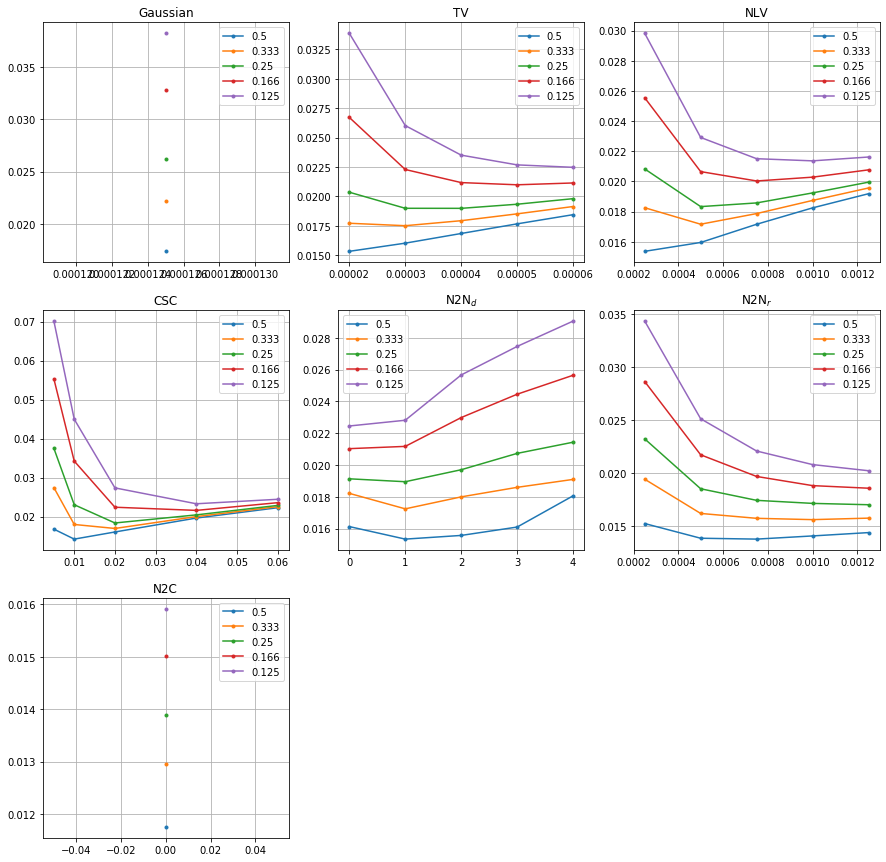

In [27]:
# plot
nFigures = len(lossList)
nCols = int(np.min([np.ceil(np.sqrt(nFigures)), 3]))
nRows = int(np.ceil(nFigures / nCols))

plt.figure(figsize=[5 * nRows, 5 * nCols])
for i, name in enumerate(lossList):
    plt.subplot(nRows, nCols, i + 1)
    for dose in doseLevel:
        plt.plot(lossList[name]['gammas'][dose], lossList[name]['rmses'][dose], '.-')
    plt.legend(doseLevel)
    plt.grid(True)
    plt.title(name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


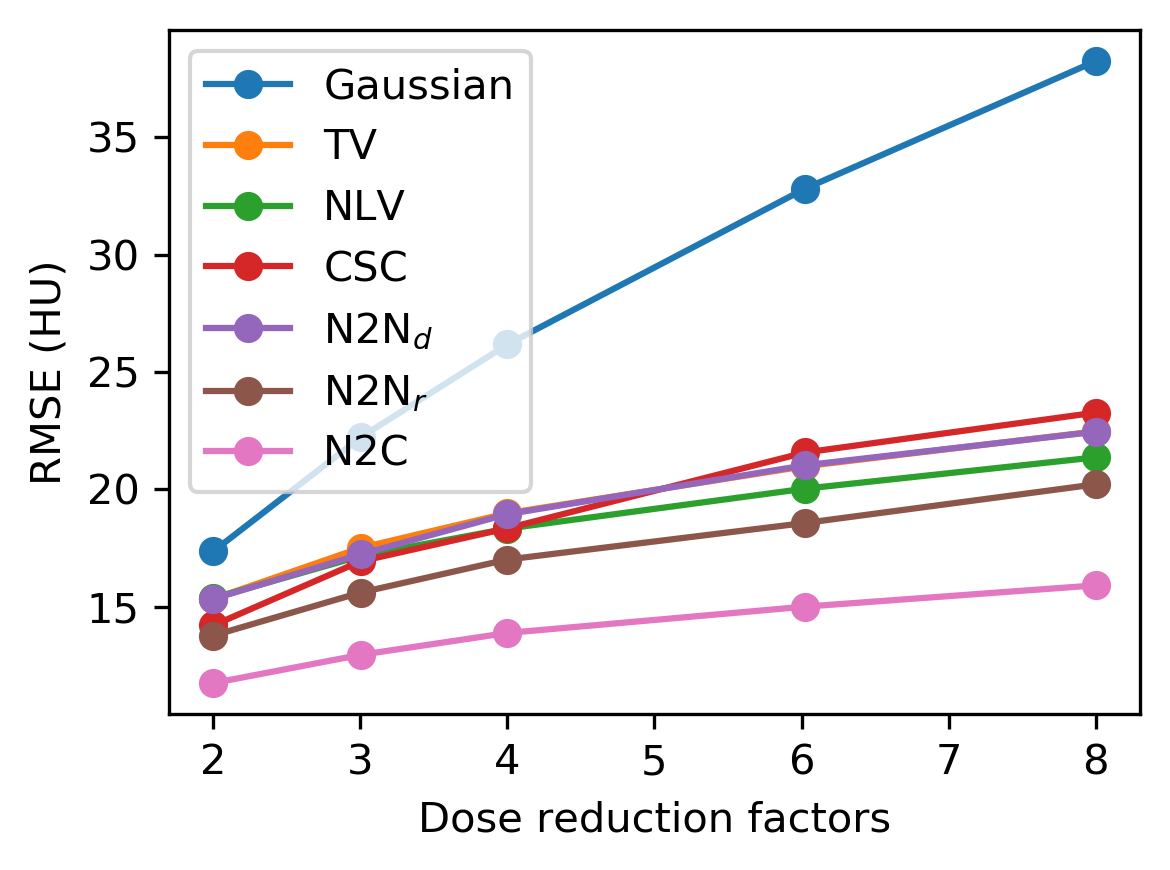

In [6]:
# plot the best rmses for each dose
rmses = {}
for name in lossList:
    rmses[name] = [min(lossList[name]['rmses'][dose])*1000 for dose in doseLevel]
plt.figure(figsize=[4,3], dpi=300)
for name in rmses:
    plt.plot(1 / np.array(doseLevel), rmses[name], 'o-')
plt.legend(lossList.keys())
plt.xlabel('Dose reduction factors')
plt.ylabel('RMSE (HU)')
plt.tight_layout()

plt.savefig('../../train/recon/eval/dose.eps')

In [32]:
print (doseLevel)
for name in lossList:
    gammas = [lossList[name]['gammas'][dose][np.argmin(lossList[name]['rmses'][dose])] for dose in doseLevel]
    
    print (name, gammas)

[0.5, 0.333, 0.25, 0.166, 0.125]
Gaussian [0.000125, 0.000125, 0.000125, 0.000125, 0.000125]
TV [2e-05, 3e-05, 4e-05, 5e-05, 6e-05]
NLV [0.00025, 0.0005, 0.0005, 0.00075, 0.001]
CSC [0.01, 0.02, 0.02, 0.04, 0.04]
N2N$_d$ [1.0, 1.0, 1.0, 0.0, 0.0]
N2N$_r$ [0.00075, 0.001, 0.00125, 0.00125, 0.00125]
N2C [0, 0, 0, 0, 0]
